In [1]:
import os
import sys
import cv2
import time
import timeit
import torch
import random
import pathlib
import logging
import numpy as np
import albumentations
from tqdm import tqdm
from functools import partial

from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from mmcv.runner import build_optimizer

from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
from torchviz import make_dot
from models.segformer import Segformer

%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)

from utils.label_utils import get_labels
from utils.lr_schedule import PolyLrUpdater
from utils.modelsummary import get_model_summary
from utils.runners import train, validate, testval
from utils.data_utils import label_mapping, SegmentationDataset, display, cityscapes_label_to_rgb
from utils.train_utils import AverageMeter, CrossEntropy, get_confusion_matrix, create_logger
from utils.transformations import (ComposeDouble, FunctionWrapperDouble, normalize, re_normalize,
                                   random_crop, random_resize, random_brightness, AlbuSeg2d, scale_aug)

from configs.segformer_config import config as cfg

labels = get_labels()
id2label =      { label.id      : label for label in labels }
trainid2label = { label.trainId : label for label in labels }

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
transforms_training = ComposeDouble([
    FunctionWrapperDouble(random_resize, scale_factor=16, base_size=cfg.DATASET.BASE_SIZE[1], both=True),
    FunctionWrapperDouble(random_crop, crop_size=cfg.DATASET.CROP_SIZE, 
                          ignore_label=cfg.DATASET.IGNORE_LABEL, both=True),
    AlbuSeg2d(albumentations.HorizontalFlip(p=0.5)),
    FunctionWrapperDouble(label_mapping, label_map=id2label, input=False, target=True),
    FunctionWrapperDouble(random_brightness, input=True, target=False),
    FunctionWrapperDouble(normalize, mean=cfg.DATASET.MEAN, std=cfg.DATASET.STD, input=True, target=False),
    FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
])


transforms_validation = ComposeDouble([
    FunctionWrapperDouble(random_crop, crop_size=cfg.DATASET.CROP_SIZE, 
                          ignore_label=cfg.DATASET.IGNORE_LABEL, both=True),
    FunctionWrapperDouble(label_mapping, label_map=id2label, input=False, target=True),
    FunctionWrapperDouble(normalize, mean=cfg.DATASET.MEAN, std=cfg.DATASET.STD, input=True, target=False),
    FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
])

In [3]:
train_dataset = SegmentationDataset(cfg = cfg.DATASET, split = "train", transform = transforms_training)
valid_dataset = SegmentationDataset(cfg = cfg.DATASET, split = "val", transform = transforms_validation)

train_dataloader = DataLoader(
    dataset = train_dataset, 
    batch_size = cfg.TRAIN.ADJ_BATCH_SIZE, 
    shuffle = True,
    drop_last = True,
    num_workers = 4,
    prefetch_factor = 8,
    pin_memory=True
    
)
valid_dataloader = DataLoader(
    dataset = valid_dataset, 
    batch_size = cfg.TRAIN.ADJ_BATCH_SIZE, 
    shuffle = True,
    drop_last = True,
    num_workers = 8,
    prefetch_factor = 16,
    pin_memory=True
    
)

x, y, _, names = next(iter(train_dataloader))
xv, yv, _, vnames = next(iter(valid_dataloader))

x_min, x_max = x.min(), x.max()
print('x.shape: {}, x.type: {}, [min(x), max(x)]: [{:.3f}, {:.3f}]'.format(x.numpy().shape, x.dtype, x_min, x_max))
print('y.shape: {}, y.type: {} \ny unique: {}'.format(y.numpy().shape, y.dtype, np.unique(y.numpy()).tolist()))

Images: 2975 , Labels: 2975
Images: 500 , Labels: 500
x.shape: (4, 3, 768, 768), x.type: torch.float32, [min(x), max(x)]: [-2.118, 2.501]
y.shape: (4, 768, 768), y.type: torch.int64 
y unique: [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 17, 18, 255]


In [4]:
def display_blend(display_list):
    plt.figure(figsize=(10, 10), dpi=200)
    for i in range(len(display_list)):
        blend = cv2.addWeighted(display_list[i][0], 0.8, display_list[i][1], 0.6, 0)
        plt.subplot(1, len(display_list), i+1)
        plt.imshow(blend)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

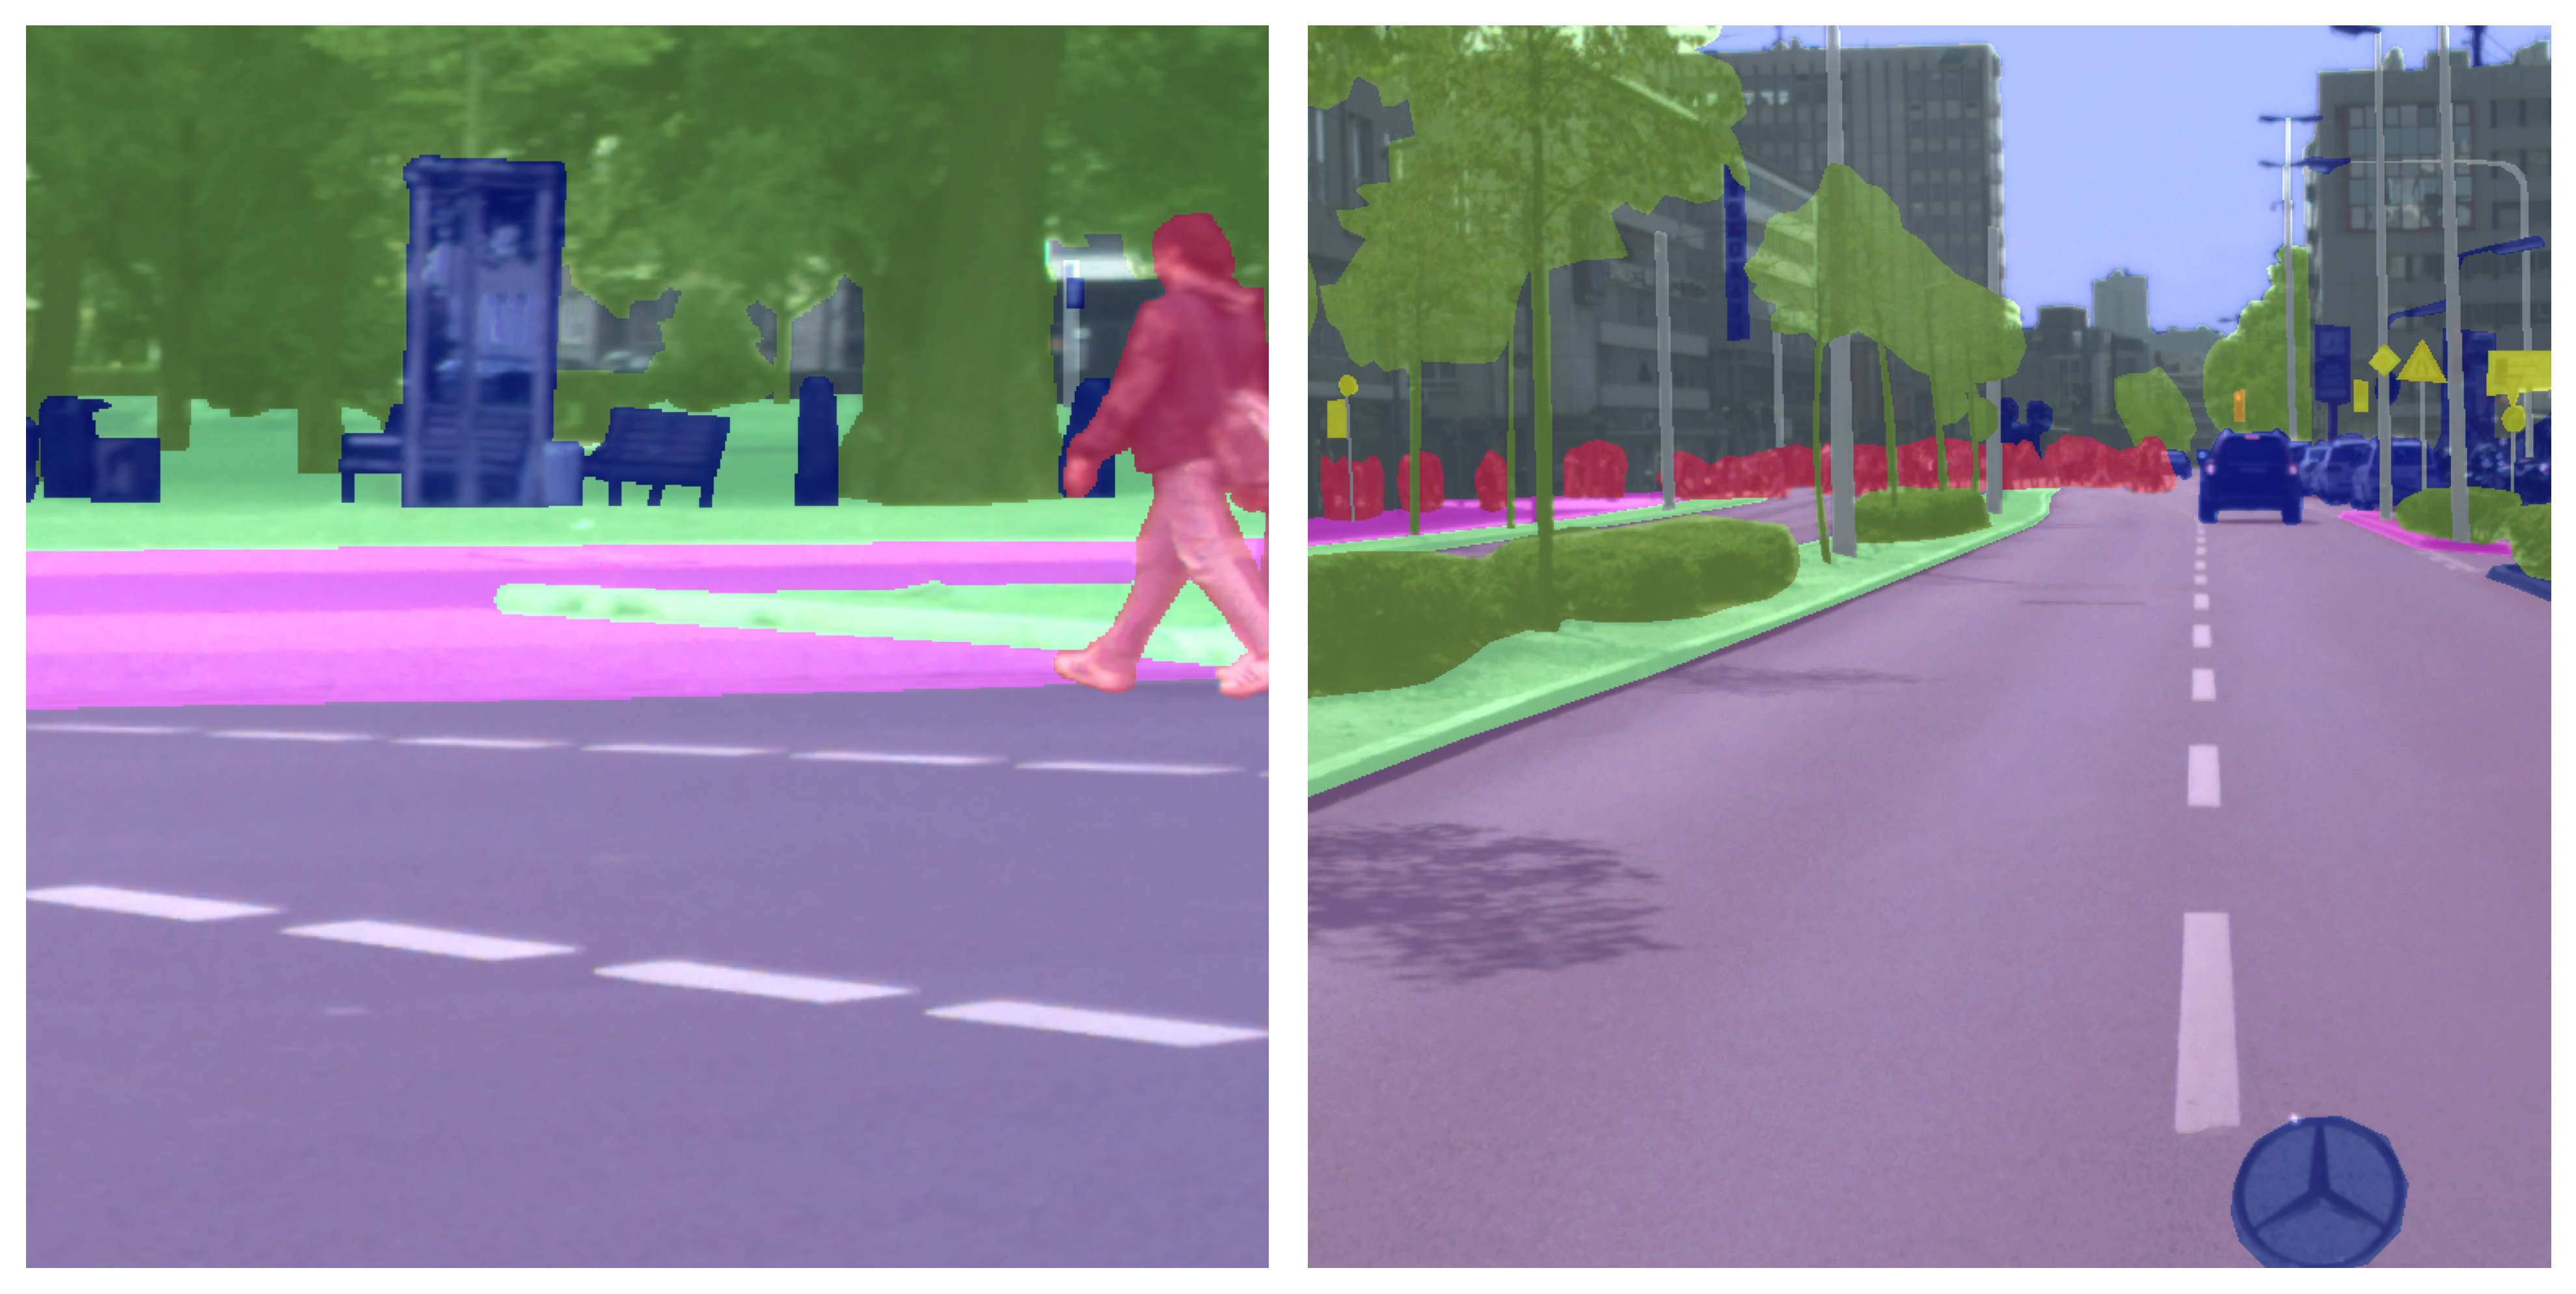

In [5]:
idx = 0
display_blend([
    [re_normalize(x[idx].permute(1,2,0).numpy()), cityscapes_label_to_rgb(y[idx])],
    [re_normalize(xv[idx].permute(1,2,0).numpy()), cityscapes_label_to_rgb(yv[idx])]
])

In [6]:
SEG_CFG = cfg.MODEL.B2

In [7]:
model = Segformer(
    pretrained = SEG_CFG.PRETRAINED,
    img_size = cfg.DATASET.CROP_SIZE[0], 
    patch_size = cfg.MODEL.PATCH_SIZE, 
    embed_dims = SEG_CFG.CHANNEL_DIMS, 
    num_heads = SEG_CFG.NUM_HEADS, 
    mlp_ratios = SEG_CFG.MLP_RATIOS,
    qkv_bias = SEG_CFG.QKV_BIAS, 
    depths = SEG_CFG.DEPTHS, 
    sr_ratios = SEG_CFG.SR_RATIOS,
    drop_rate = SEG_CFG.DROP_RATE, 
    drop_path_rate = SEG_CFG.DROP_PATH_RATE,
    decoder_dim = SEG_CFG.DECODER_DIM,
    norm_layer = partial(nn.LayerNorm, eps=1e-6), 
).to(device)

2021-09-06 11:50:10,652 - mmseg - INFO - Use load_from_local loader
2021-09-06 11:50:10,714 - mmseg - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: head.weight, head.bias

missing keys in source state_dict: linear_c4.proj.weight, linear_c4.proj.bias, linear_c3.proj.weight, linear_c3.proj.bias, linear_c2.proj.weight, linear_c2.proj.bias, linear_c1.proj.weight, linear_c1.proj.bias, linear_fuse.weight, linear_fuse.bias, linear_pred.weight, linear_pred.bias



In [8]:
criterion = CrossEntropy(
    ignore_label=cfg.DATASET.IGNORE_LABEL, 
    weight=train_dataset.class_weights
).to(device)


optimizer_cfg = dict(
    type=cfg.TRAIN.OPTIMIZER, 
    lr=cfg.TRAIN.BASE_LR,  
    weight_decay=cfg.TRAIN.WD,
    paramwise_cfg=dict(
        custom_keys={
            'pos_block': dict(decay_mult=0.), 
            'norm': dict(decay_mult=0.),
            'head': dict(lr_mult=10.)
        }
))

optimizer = build_optimizer(model, optimizer_cfg)

lr_scheduler = PolyLrUpdater(
    optimizer = optimizer,
    power = cfg.TRAIN.POWER,
    min_lr = cfg.TRAIN.MIN_LR,
    max_iters = cfg.TRAIN.DECAY_STEPS,
    epoch_len = len(train_dataloader),
    warmup = cfg.TRAIN.WARMUP,
    warmup_iters = cfg.TRAIN.WARMUP_ITERS,
    warmup_ratio = cfg.TRAIN.WARMUP_RATIO,
    by_epoch = cfg.TRAIN.BY_EPOCH,
)

In [9]:
details = get_model_summary(model, x.cuda(), verbose=True)
print(details)

Model Summary
Name                Input Size          Output Size         Parameters          Multiply Adds (Flops)
----------------------------------------------------------------------------------------------------
Conv2d_1            [4, 3, 768, 768]    [4, 64, 192, 192]   9472                346816512           
----------------------------------------------------------------------------------------------------
LayerNorm_1         [4, 36864, 64]      [4, 36864, 64]      0                   Not Available       
----------------------------------------------------------------------------------------------------
OverlapPatchEmbed_1 [4, 3, 768, 768]    [4, 36864, 64]      0                   Not Available       
----------------------------------------------------------------------------------------------------
LayerNorm_2         [4, 36864, 64]      [4, 36864, 64]      0                   Not Available       
----------------------------------------------------------------------------

In [10]:
def train(
    cfg, 
    dataloader, 
    model, 
    loss_fn, 
    optimizer, 
    lr_scheduler, 
    scaler, 
    writer_dict,
    epoch, 
):
    model.train()
    
    ave_loss = AverageMeter()
    steps_tot = epoch*len(dataloader) 
    writer = writer_dict['writer']
    global_steps = writer_dict['train_global_steps']
    
    for step, batch in enumerate(dataloader):
        X, y, _, _ = batch
        X, y = X.cuda(), y.long().cuda() 
        
        # Compute prediction and loss
        with torch.cuda.amp.autocast():
            pred = model(X.contiguous())
            pred = F.interpolate(pred, size = cfg.DATASET.CROP_SIZE, mode = 'bilinear', align_corners = False)
            losses = loss_fn(pred, y)
        loss = losses.mean()
        
        # Normalize loss to account for batch accumulation
        loss = loss / cfg.TRAIN.ACCUM_STEPS
            
        # Backward pass
        scaler.scale(loss).backward()
        
        # Weight update
        if ((step + 1) % cfg.TRAIN.ACCUM_STEPS == 0) or (step + 1 == len(dataloader)):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

            # update average loss
            ave_loss.update(loss.item())

            # update learning schedule
            lr_scheduler.before_train_iter()
            lr = lr_scheduler.get_lr(int(steps_tot+step), cfg.TRAIN.BASE_LR)
        
        
    writer.add_scalar('train_loss', ave_loss.average(), global_steps)
    writer_dict['train_global_steps'] = global_steps + 1
    
    
def validate(
    cfg, 
    dataloader, 
    model, 
    loss_fn, 
    writer_dict
):
    model.eval()
    
    ave_loss = AverageMeter()
    iter_steps = len(dataloader.dataset) // cfg.TRAIN.BATCH_SIZE
    confusion_matrix = np.zeros((cfg.DATASET.NUM_CLASSES, cfg.DATASET.NUM_CLASSES, 1))
    
    with torch.no_grad():
        for idx, batch in enumerate(dataloader):
            X, y, _, _ = batch
            size = y.size()
            X, y = X.cuda(), y.long().cuda()
            
            pred = model(X.contiguous())
            pred = F.interpolate(pred, size = cfg.DATASET.CROP_SIZE, mode = 'bilinear', align_corners = False)
            losses = loss_fn(pred, y)
            loss = losses.mean()   
            
            if not isinstance(pred, (list, tuple)):
                pred = [pred]    
            for i, x in enumerate(pred):
                confusion_matrix[..., i] += get_confusion_matrix(
                    y, x, size, cfg.DATASET.NUM_CLASSES, cfg.DATASET.NUM_CLASSES)
            ave_loss.update(loss.item())
            
    pos = confusion_matrix[..., 0].sum(1)
    res = confusion_matrix[..., 0].sum(0)
    tp = np.diag(confusion_matrix[..., 0])
    IoU_array = (tp / np.maximum(1.0, pos + res - tp))
    mean_IoU = IoU_array.mean()
    
    writer = writer_dict['writer']
    global_steps = writer_dict['valid_global_steps']
    writer.add_scalar('valid_loss', ave_loss.average(), global_steps)
    writer.add_scalar('valid_mIoU', mean_IoU, global_steps)
    for key, val in trainid2label.items():
        if key != cfg.DATASET.IGNORE_LABEL and key != -1:
            if val.name == 'traffic light':
                val_name = "traffic_light"
            elif val.name == 'traffic sign':
                val_name = "traffic_sign"
            else:
                val_name = val.name
            writer.add_scalar('valid_mIoU_{}'.format(val_name), IoU_array[key], global_steps)    
    writer_dict['valid_global_steps'] = global_steps + 1
        
    return ave_loss.average(), mean_IoU, IoU_array

In [11]:
def run_train_loop():
    
    logger, final_output_dir, tb_log_dir = create_logger(cfg, cfg_name=cfg.NAME, phase='train')
    
    writer_dict = {'writer': SummaryWriter(tb_log_dir), 'train_global_steps': 0, 'valid_global_steps': 0}

    best_mIoU = 0

    start = timeit.default_timer()
    for epoch in range(cfg.TRAIN.EPOCHS):

        train(
            cfg=cfg, 
            dataloader=train_dataloader, 
            model=model, 
            loss_fn=criterion, 
            optimizer=optimizer, 
            lr_scheduler=lr_scheduler,
            epoch=epoch, 
            scaler=torch.cuda.amp.GradScaler(),
            writer_dict=writer_dict
        )

        valid_loss, mean_IoU, IoU_array = validate(
            cfg=cfg, 
            dataloader=valid_dataloader, 
            model=model,  
            loss_fn=criterion,
            writer_dict=writer_dict
        )

        # logger.info('=> saving checkpoint to {}'.format(final_output_dir + 'checkpoint.pth.tar'))

        torch.save({
            'epoch': epoch+1,
            'best_mIoU': best_mIoU,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }, os.path.join(final_output_dir,'checkpoint.pth.tar'))

        if mean_IoU > best_mIoU:
            best_mIoU = mean_IoU
            torch.save(model.state_dict(), os.path.join(final_output_dir, 'best.pth'))

        msg = 'Epoch {}/{} --- Loss: {:.3f}, MeanIU: {: 4.4f}, Best_mIoU: {: 4.4f} \n'.format(
            epoch+1, cfg.TRAIN.EPOCHS, valid_loss, mean_IoU, best_mIoU)
        logging.info(msg)
        
    torch.save(model.state_dict(), os.path.join(final_output_dir, 'final_state.pth'))

    writer_dict['writer'].close()
    end = timeit.default_timer()
    logger.info('Hours: %d' % np.int((end-start)/3600))
    logger.info('Done')

In [ ]:
run_train_loop()

=> creating /workspace/PythonProjects/segmentation_pytorch/outputs/cityscapes/segformer_train_1024x1024_adamw_lr6e-6_wd1e-2_bs_8_epoch400
=> creating /workspace/PythonProjects/segmentation_pytorch/logs/cityscapes/segformer/segformer_train_1024x1024_adamw_lr6e-6_wd1e-2_bs_8_epoch400_2021-09-06-11-50



 Epoch 1/400 --- Loss: 0.364, MeanIU:  0.4462, Best_mIoU:  0.4462 


 Epoch 2/400 --- Loss: 0.292, MeanIU:  0.5297, Best_mIoU:  0.5297 


 Epoch 3/400 --- Loss: 0.272, MeanIU:  0.5630, Best_mIoU:  0.5630 


 Epoch 4/400 --- Loss: 0.250, MeanIU:  0.5735, Best_mIoU:  0.5735 


 Epoch 5/400 --- Loss: 0.261, MeanIU:  0.5733, Best_mIoU:  0.5735 


 Epoch 6/400 --- Loss: 0.226, MeanIU:  0.6004, Best_mIoU:  0.6004 


 Epoch 7/400 --- Loss: 0.220, MeanIU:  0.6200, Best_mIoU:  0.6200 


 Epoch 8/400 --- Loss: 0.210, MeanIU:  0.6287, Best_mIoU:  0.6287 


 Epoch 9/400 --- Loss: 0.198, MeanIU:  0.6585, Best_mIoU:  0.6585 


 Epoch 10/400 --- Loss: 0.211, MeanIU:  0.6588, Best_mIoU:  0.6588 


 Epoch 11/400 --- Loss: 0.213, MeanIU:  0.6153, Best_mIoU:  0.6588 


 Epoch 12/400 --- Loss: 0.210, MeanIU:  0.6220, Best_mIoU:  0.6588 


 Epoch 13/400 --- Loss: 0.214, MeanIU:  0.6374, Best_mIoU:  0.6588 


 Epoch 14/400 --- Loss: 0.181, MeanIU:  0.6970, Best_mIoU:  0.6970 



In [ ]:
mean_IoU, IoU_array, pixel_acc, mean_acc = testval(
    config, 
    eval_dataloader, 
    model, 
    sv_dir=cfg.OUTPUT_DIR, 
    sv_pred=True
)

In [ ]:
print("mnea IoU: {:.3f}, mean Accuracy: {:.3f}, Pixel Accuracy: {:.3f}".format(mean_IoU, mean_acc, pixel_acc))

In [ ]:
for key, val in trainid2label.items():
    if key != cfg.DATASET.IGNORE_LABEL and key != -1:
        print("{} --- IoU: {:.2f}".format(val.name, IoU_array[key]))